# TEXT PREPROCESSING AND SENTIMENT ANALYSIS

## Importing the required Libraries

In [1]:
import pandas as pd
import json
import gzip
import re
import spacy                                                 
from spacy.lang.en import English                             # Import specific model
nlp = spacy.load("en_core_web_sm")                            # Load model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score,classification_report,plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Loading the Datafile which we used for EDA

In [2]:
df_final=pd.read_csv("finally_done.csv")
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2


## Checking the shape of our dataframe

In [3]:
df_final.shape

(21272, 14)

## Defining functions for modular coding purpose

In [4]:
def null_values(df):
    print(f"Total null values with repect too each column are:- {df.isnull().sum()}")

In [5]:
def per_null(df,col):
    null=df[col].isnull().sum()
    total=len(df)
    percent=(null/total)*100
    print(f"Percentage of null values are {round(percent,2)}")

In [6]:
def val_count(df,col):
    print(f"Counts of each category are {df[col].value_counts()}")

In [7]:
def n_unq(df,col):
    print(f"No. of unique values are {df[col].nunique()}")

## We are removing some words from the stopwords in order to retain sentiments of the review


In [8]:
nlp.Defaults.stop_words-={'against','cannot','bottom','except','least','less','never','none','Noone','no','nobody','nothing','nor',"n't"}

## final review by combining the summary and review

In [9]:
df_final['final_review']=df_final['reviewText']+' '+df_final['summary']

## We are doing the contraction for some words for stopwords

In [10]:
contract = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have"}


In [11]:
def cont_to_exp(x):
    if x in contract.keys():
        value=contract[x]
    else:
        value=x
    return value

In [12]:
df_final.head(2)

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,This handcream has a beautiful fragrance. It d...
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,There is no evidence to me that this product i...


## Defining and performing functions for cleaning the texts,Lemmatization and text preprocessing part

In [13]:
def clean_text(text):
    """
    Return clean version of the text
    """
    text = text.lower()
    text = ' '.join(list((cont_to_exp(t) for t in text.split())))    
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    #Remove all Urls
    text=re.sub('http\S+','_URL_ ', text)
    # Remove multiple spaces
    text = " ".join(text.split())
    

    return text

df_final['final_review'] = df_final['final_review'].apply(clean_text)
print(df_final['final_review'][:5])

0    this handcream has a beautiful fragrance it do...
1    there is no evidence to me that this product i...
2    wonderful hand lotion for seriously dry skin s...
3    best hand cream around silky thick soaks in al...
4    great hand lotion soaks right in and leaves sk...
Name: final_review, dtype: object


# Performing the classification and doing the evaluation for different classification models

In [14]:
from nltk.corpus import stopwords
stop_words_nltk = stopwords.words('english')

In [15]:
stop_words_nltk.remove('not')

In [16]:
l=['once','not','no','nor',"don't","couldn't","aren't","didn't","shouldn't","doesn't","hadn't","hasn't","haven't","isn't","mustn't","wasn't","wouldn't"]

In [17]:
for i in l:
    if i in stop_words_nltk:
        stop_words_nltk.remove(i)

In [18]:
stop_words_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few'

In [19]:
len(stop_words_nltk)

162

In [20]:
for i in range(len(df_final['final_review'])):
    doc=nlp(str(df_final['final_review'][i]))
    filt=[]
    for word in doc:
        if word.is_stop==False:                                               
            filt.append(word.lemma_)
    df_final['final_review'][i]=" ".join(filt) 
df_final['final_review'][:5]

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\1781671299.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['final_review'][i]=" ".join(filt)


0    handcream beautiful fragrance not stay protect...
1    no evidence product improvement similarly pric...
2    wonderful hand lotion seriously dry skin stay ...
3    good hand cream silky thick soak way leave han...
4    great hand lotion soak right leave skin super ...
Name: final_review, dtype: object

### Clasification Using Polarity

In [21]:
from textblob import TextBlob
df_final['polarity']=df_final['final_review'].apply( lambda x : TextBlob(x).sentiment.polarity)
df_final['polarity']

0        0.483333
1       -0.083333
2        0.346250
3        0.306667
4        0.519841
           ...   
21267    0.243673
21268    0.174956
21269   -0.042727
21270    0.343265
21271    0.218182
Name: polarity, Length: 21272, dtype: float64

In [22]:
df_final.loc[(df_final["polarity"] > 0) , 'blobsentiment'] = 'Positive'
df_final.loc[(df_final["polarity"] == 0) , 'blobsentiment'] = 'Neutral'
df_final.loc[(df_final["polarity"] < 0) , 'blobsentiment'] = 'Negative'

In [23]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive


In [24]:
df_final.to_csv('abc.csv',index=False)

In [25]:
df_final_dup=df_final.copy()

In [27]:
len(df_final['polarity'])

21272

In [28]:
len(df_final[df_final['polarity']<0])

1692

In [29]:
len(df_final[df_final['polarity']==0])

591

In [30]:
len(df_final[df_final['polarity']>0])

18989

In [31]:
df_final_dup.reset_index(inplace=True)
dataset = df_final_dup[['final_review', 'blobsentiment']]
dataset.head(2)

,final_review,blobsentiment
0,handcream beautiful fragrance not stay protect...,Positive
1,no evidence product improvement similarly pric...,Negative


## Sentiments biased towards positive



In [32]:
dataset['blobsentiment'].value_counts()/len(dataset)

Positive    0.892676
Negative    0.079541
Neutral     0.027783
Name: blobsentiment, dtype: float64

In [33]:
dataset.shape

(21272, 2)


# lets check the distribution of data on the test data and see if the representation of the target variable is the close to the original sample

#### Splittig the data into train|test

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 
for train_index, test_index in split.split(dataset, dataset['blobsentiment']):
    strat_train_set = dataset.iloc[train_index]
    strat_test_set = dataset.iloc[test_index]

In [35]:
strat_test_set['blobsentiment'].value_counts()/len(strat_test_set)

Positive    0.892597
Negative    0.079671
Neutral     0.027732
Name: blobsentiment, dtype: float64

In [36]:
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

Positive    0.892696
Negative    0.079509
Neutral     0.027796
Name: blobsentiment, dtype: float64

In [37]:
#import necessary nltk libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import Wordnet, Translate

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
t=Wordnet()
#test
sentence ='Hello, I have been so exhausted lately. I need to rest'
t.augment(sentence)

'hello, i own personify so exhausted lately. i involve to rest'

In [39]:
#augment reviews with sentiment not equal to positive
augmented = pd.DataFrame()
for i in strat_train_set[strat_train_set['blobsentiment'] != 'Positive'].index:
    text_aug = t.augment(str(strat_train_set['final_review'][i]))
    augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\463066721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipyk

In [40]:
import numpy as np

In [41]:
#drop 70% of records with scores equal to Positive and add augmented to train set

part_na = round(strat_train_set[strat_train_set['blobsentiment'] == 'Positive'].shape[0]*0.7)
strat_train_set.head()
five_indices = strat_train_set[strat_train_set.blobsentiment=='Positive' ].index
random_indices = np.random.choice(five_indices, part_na, replace= False)
random_indices 

array([   21, 21210,   105, ..., 10628,   113, 20120], dtype=int64)

In [42]:
strat_train_set.drop(random_indices, inplace = True)
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\4162044909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set.drop(random_indices, inplace = True)


Positive    0.713928
Negative    0.211969
Neutral     0.074103
Name: blobsentiment, dtype: float64

In [43]:
#append augmented to strat_train_set
strat_train_set = strat_train_set.append(augmented)
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\660701749.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strat_train_set = strat_train_set.append(augmented)


Positive    0.555122
Negative    0.329638
Neutral     0.115239
Name: blobsentiment, dtype: float64

In [44]:
strat_train_set.shape

(8209, 2)

In [45]:
strat_test_set.shape

(4255, 2)

# TF-IDF VECTORIZER

In [46]:
def funct(classifier,input_train,input_test,label_train,label_test):
    vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=1,stop_words=stopwords.words('english'),use_idf=True,smooth_idf=True)
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

### (ii) Count Vectorizer with n grams

In [47]:
def funct_ngrams(classifier,input_train,input_test,label_train,label_test):
    vectorizer=CountVectorizer(ngram_range=(1,2))
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

In [48]:
from sklearn.naive_bayes import MultinomialNB

# Vectorization technique used in below models is TF-IDF

# Multinomial Naviye Bayes

In [49]:
model_1=MultinomialNB()

In [50]:
X_train=strat_train_set['final_review']
X_test=strat_test_set['final_review']
y_train=strat_train_set['blobsentiment']
y_test=strat_test_set['blobsentiment']

In [51]:
model_1=MultinomialNB()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.72      0.15      0.25       339
     Neutral       1.00      0.08      0.16       118
    Positive       0.91      1.00      0.95      3798

    accuracy                           0.90      4255
   macro avg       0.88      0.41      0.45      4255
weighted avg       0.89      0.90      0.87      4255

accuracy: 0.9034077555816686
recall: 0.9034077555816686
f1-score: 0.8715140515404606
precision: 0.8942350001675479


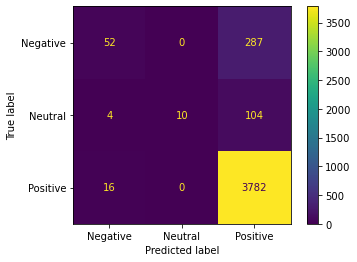

In [52]:
actual_1,predicted_1,vect_1=funct(model_1,strat_train_set['final_review'],strat_test_set['final_review'],strat_train_set['blobsentiment'],strat_test_set['blobsentiment'])

In [53]:
def funct_1(classifier,input_train,input_test,label_train,label_test):
    vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=1,stop_words=stopwords.words('english'),use_idf=True,smooth_idf=True)
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    model_score=clf.score(X_train,y_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer,model_score

In [54]:
model_2=MultinomialNB()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.72      0.15      0.25       339
     Neutral       1.00      0.08      0.16       118
    Positive       0.91      1.00      0.95      3798

    accuracy                           0.90      4255
   macro avg       0.88      0.41      0.45      4255
weighted avg       0.89      0.90      0.87      4255

accuracy: 0.9034077555816686
recall: 0.9034077555816686
f1-score: 0.8715140515404606
precision: 0.8942350001675479


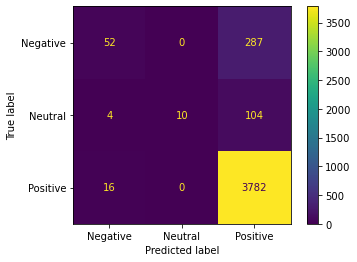

In [55]:
actual_j,predicted_j,vect_j,acc=funct_1(model_2,X_train,X_test,y_train,y_test)


In [56]:
acc

0.7461322938238518

In [57]:
accuracy_1=[]
recall_1=[]
precision_1=[]
f1score_1=[]
model_name_1=[]

In [58]:
accuracy_1.append(accuracy_score(actual_1,predicted_1))
recall_1.append(recall_score(actual_1,predicted_1,average='weighted'))
precision_1.append(precision_score(actual_1,predicted_1,average='weighted'))
f1score_1.append(f1_score(actual_1,predicted_1,average='weighted'))
model_name_1.append('Multinomial Naviye bayes with TF-IDF VECTORIZER')

# Logistic Regression with One Vs Rest Classifier

In [59]:
lr_2 = LogisticRegression(max_iter=200, verbose=1)
ovr_2 = OneVsRestClassifier(lr_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.61      0.81      0.69       339
     Neutral       0.67      0.66      0.67       118
    Positive       0.98      0.95      0.96      3798

    accuracy                           0.93      4255
   macro avg       0.75      0.81      0.78      4255
weighted avg       0.94      0.93      0.93      4255

accuracy: 0.9306698002350177
recall: 0.9306698002350177
f1-score: 0.9342098762253064
precision: 0.9404792233838035


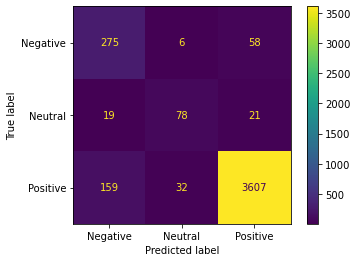

In [60]:
actual_2,predicted_2,vect_2=funct(ovr_2,X_train,X_test,y_train,y_test)

In [61]:
accuracy_1.append(accuracy_score(actual_2,predicted_2))
recall_1.append(recall_score(actual_2,predicted_2,average='weighted'))
precision_1.append(precision_score(actual_2,predicted_2,average='weighted'))
f1score_1.append(f1_score(actual_2,predicted_2,average='weighted'))
model_name_1.append('Logistic Regression (One Vs Rest Classifier) with TF-IDF VECTORIZER')

# Decission Tree Classifier

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [64]:
classif_3=DecisionTreeClassifier()

In [65]:
grid_3 = GridSearchCV(estimator=classif_3, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.24      0.78      0.37       339
     Neutral       0.33      0.59      0.42       118
    Positive       0.98      0.76      0.86      3798

    accuracy                           0.76      4255
   macro avg       0.52      0.71      0.55      4255
weighted avg       0.90      0.76      0.81      4255

accuracy: 0.7569917743830787
recall: 0.7569917743830787
f1-score: 0.805381376396607
precision: 0.9032058795747282


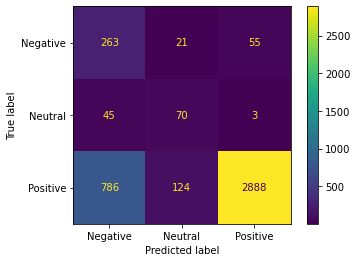

In [66]:
actual_3,predicted_3,vect_3=funct(grid_3,X_train,X_test,y_train,y_test)

In [67]:
accuracy_1.append(accuracy_score(actual_3,predicted_3))
recall_1.append(recall_score(actual_3,predicted_3,average='weighted'))
precision_1.append(precision_score(actual_3,predicted_3,average='weighted'))
f1score_1.append(f1_score(actual_3,predicted_3,average='weighted'))
model_name_1.append('Decision tree classifier with TF-IDF VECTORIZER')

# Random Forest using Grid Search CV

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [70]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [71]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.50      0.26      0.34       339
     Neutral       0.73      0.19      0.30       118
    Positive       0.91      0.98      0.94      3798

    accuracy                           0.90      4255
   macro avg       0.72      0.47      0.53      4255
weighted avg       0.88      0.90      0.88      4255

accuracy: 0.8963572267920094
recall: 0.8963572267920094
f1-score: 0.8779957570003848
precision: 0.8765056236360584


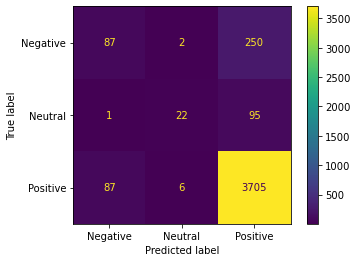

In [72]:
actual_4,predicted_4,vect_4=funct(grid_search,X_train,X_test,y_train,y_test)

In [73]:
accuracy_1.append(accuracy_score(actual_4,predicted_4))
recall_1.append(recall_score(actual_4,predicted_4,average='weighted'))
precision_1.append(precision_score(actual_4,predicted_4,average='weighted'))
f1score_1.append(f1_score(actual_4,predicted_4,average='weighted'))
model_name_1.append('Random Forest Classifier with TF-IDF VECTORIZER')

# Vectorization technique used in below models is Count-Vectorizer with n-grams (1,2)

# Multinomial Naviye Bayes

In [74]:
model_5=MultinomialNB()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.63      0.33      0.44       339
     Neutral       0.89      0.27      0.42       118
    Positive       0.93      0.99      0.96      3798

    accuracy                           0.91      4255
   macro avg       0.81      0.53      0.60      4255
weighted avg       0.90      0.91      0.90      4255

accuracy: 0.9146886016451233
recall: 0.9146886016451233
f1-score: 0.8997488487003797
precision: 0.9027329447923225


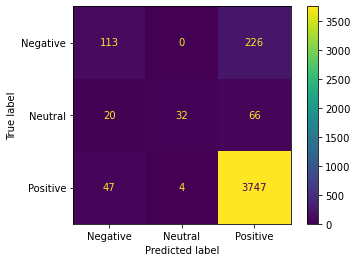

In [75]:
actual_5,predicted_5,vect_5=funct_ngrams(model_5,X_train,X_test,y_train,y_test)

In [76]:
accuracy_1.append(accuracy_score(actual_5,predicted_5))
recall_1.append(recall_score(actual_5,predicted_5,average='weighted'))
precision_1.append(precision_score(actual_5,predicted_5,average='weighted'))
f1score_1.append(f1_score(actual_5,predicted_5,average='weighted'))
model_name_1.append('Multinomial Naviye bayes with Count Vectorizer')

# Logistic Regression with One Vs Rest Classifier

In [77]:
lr_6 = LogisticRegression(max_iter=200, verbose=1)
ovr_6 = OneVsRestClassifier(lr_6)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.62      0.82      0.70       339
     Neutral       0.54      0.85      0.66       118
    Positive       0.99      0.94      0.96      3798

    accuracy                           0.93      4255
   macro avg       0.71      0.87      0.78      4255
weighted avg       0.94      0.93      0.93      4255

accuracy: 0.9278495887191539
recall: 0.9278495887191539
f1-score: 0.933632620996131
precision: 0.9445470563694298


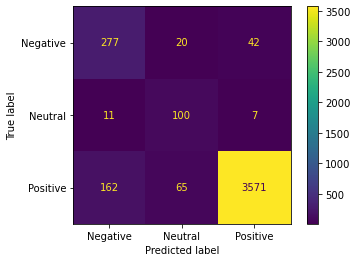

In [78]:
actual_6,predicted_6,vect_6=funct_ngrams(ovr_6,X_train,X_test,y_train,y_test)

In [79]:
accuracy_1.append(accuracy_score(actual_6,predicted_6))
recall_1.append(recall_score(actual_6,predicted_6,average='weighted'))
precision_1.append(precision_score(actual_6,predicted_6,average='weighted'))
f1score_1.append(f1_score(actual_6,predicted_6,average='weighted'))
model_name_1.append('Logestic Regression with One Vs Rest Classifier with Count Vectorizer')

# Decission Tree Classifier

In [80]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [81]:
classif_7=DecisionTreeClassifier()

In [82]:
grid_7 = GridSearchCV(estimator=classif_7, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.25      0.74      0.37       339
     Neutral       0.28      0.64      0.39       118
    Positive       0.98      0.77      0.86      3798

    accuracy                           0.76      4255
   macro avg       0.50      0.72      0.54      4255
weighted avg       0.90      0.76      0.81      4255

accuracy: 0.7612220916568743
recall: 0.7612220916568743
f1-score: 0.808560648226304
precision: 0.9026301044642325


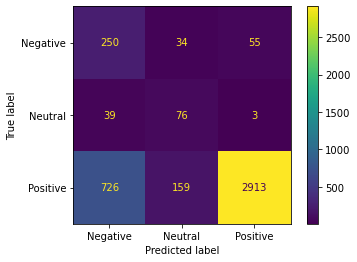

In [83]:
actual_7,predicted_7,vect_7=funct_ngrams(grid_7,X_train,X_test,y_train,y_test)

In [84]:
accuracy_1.append(accuracy_score(actual_7,predicted_7))
recall_1.append(recall_score(actual_7,predicted_7,average='weighted'))
precision_1.append(precision_score(actual_7,predicted_7,average='weighted'))
f1score_1.append(f1_score(actual_7,predicted_7,average='weighted'))
model_name_1.append('Decision tree classifier with Count vectorizer VECTORIZER')

# Random Forest using Grid Search CV

In [85]:
rf_8 = RandomForestClassifier(random_state=42, n_jobs=-1)

In [86]:
params_8 = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [87]:
grid_search_8 = GridSearchCV(estimator=rf_8,
                           param_grid=params_8,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       339
     Neutral       0.00      0.00      0.00       118
    Positive       0.89      1.00      0.94      3798

    accuracy                           0.89      4255
   macro avg       0.30      0.33      0.31      4255
weighted avg       0.80      0.89      0.84      4255

accuracy: 0.8921269095182138
recall: 0.8921269095182138
f1-score: 0.841708608210204
precision: 0.7966842234540739


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


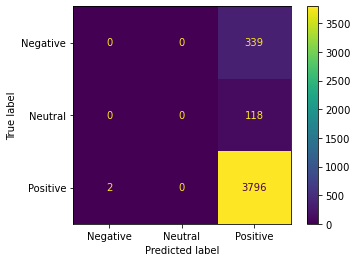

In [88]:
actual_8,predicted_8,vect_8=funct_ngrams(grid_search_8,X_train,X_test,y_train,y_test)

In [89]:
accuracy_1.append(accuracy_score(actual_8,predicted_8))
recall_1.append(recall_score(actual_8,predicted_8,average='weighted'))
precision_1.append(precision_score(actual_8,predicted_8,average='weighted'))
f1score_1.append(f1_score(actual_8,predicted_8,average='weighted'))
model_name_1.append('Random Forest Classifier with COUNT VECTORIZER')

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
df_comparision=pd.DataFrame({"model name":model_name_1,"accuracy":accuracy_1,"recall":recall_1,"precision":precision_1,"f1-score":f1score_1})

In [91]:
df_comparision

,model name,accuracy,recall,precision,f1-score
0,Multinomial Naviye bayes with TF-IDF VECTORIZER,0.903408,0.903408,0.894235,0.871514
1,Logistic Regression (One Vs Rest Classifier) w...,0.930670,0.930670,0.940479,0.934210
2,Decision tree classifier with TF-IDF VECTORIZER,0.756992,0.756992,0.903206,0.805381
3,Random Forest Classifier with TF-IDF VECTORIZER,0.896357,0.896357,0.876506,0.877996
4,Multinomial Naviye bayes with Count Vectorizer,0.914689,0.914689,0.902733,0.899749
5,Logestic Regression with One Vs Rest Classifie...,0.927850,0.927850,0.944547,0.933633
6,Decision tree classifier with Count vectorizer...,0.761222,0.761222,0.902630,0.808561
7,Random Forest Classifier with COUNT VECTORIZER,0.892127,0.892127,0.796684,0.841709


# Logistic regression with One Vs Rest Classifier with TF-IDF Vectorizer is having highest accuracy

# Model testing on unknown dataset

In [96]:
all_beaut=pd.read_csv('all_beauty_for_eda_1.csv')
all_beaut

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,year,month
0,2016-09-01,A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced,Five Stars,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2016,9
1,2013-11-14,A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...,Good for the face,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2013,11
2,2013-08-18,A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...,Smells awful,1.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2013,8
3,2011-05-03,A2UEO5XR3598GI,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2011,5
4,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,5.0,All Beauty,Citre Shine Moisture Burst Shampoo - 16 fl oz,1693702.0,23.000000,2011,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4254,2017-05-19,A2JPQVFMKT94M2,B019V2KYZS,This is so handy and unique! Comes in a protec...,Seems like it will last a long time for those ...,5.0,All Beauty,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",863502.0,9.628157,2017,5
4255,2017-05-04,AKQ9DH3HRPHW3,B019V2KYZS,This is just adorable compact fragrance. It co...,Love Love Love!!!!,5.0,All Beauty,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",863502.0,9.628157,2017,5
4256,2016-11-14,A33EQHCO5TZIP5,B019V2KYZS,always good to freshen up when traveling,Five Stars,5.0,All Beauty,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",863502.0,9.628157,2016,11
4257,2016-08-25,A3E9APU6SYF2SD,B019V2KYZS,Perfect size.,Five Stars,5.0,All Beauty,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",863502.0,9.628157,2016,8


In [97]:
all_beaut['final_review']=all_beaut['reviewText']+' '+all_beaut['summary']

In [98]:
all_beaut['final_review'] = all_beaut['final_review'].apply(clean_text)

In [99]:
for i in range(len(all_beaut['final_review'])):
    doc=nlp(str(all_beaut['final_review'][i]))
    filt=[]
    for word in doc:
        if word.is_stop==False:                                               
            filt.append(word.lemma_)
    all_beaut['final_review'][i]=" ".join(filt) 
all_beaut['final_review'][:5]

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\2195490136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_beaut['final_review'][i]=" ".join(filt)


0                      advertise reasonably price star
1    like oder feel face try brand review people kn...
2    buy smell nice shave smell awful smell like gr...
3    hey aqua velva man absolutely love stuff year ...
4    want feel pamper shampoo smell like wonderful ...
Name: final_review, dtype: object

In [100]:
all_beaut['polarity']=all_beaut['final_review'].apply( lambda x : TextBlob(x).sentiment.polarity)
all_beaut['polarity']

0       0.200000
1       0.068750
2      -0.466667
3       0.221843
4       0.291667
          ...   
4254    0.219643
4255    0.470000
4256    0.700000
4257    1.000000
4258    0.866667
Name: polarity, Length: 4259, dtype: float64

In [101]:
all_beaut.loc[(all_beaut["polarity"] > 0) , 'blobsentiment'] = 'Positive'
all_beaut.loc[(all_beaut["polarity"] == 0) , 'blobsentiment'] = 'Neutral'
all_beaut.loc[(all_beaut["polarity"] < 0) , 'blobsentiment'] = 'Negative'

In [102]:
all_beaut.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,year,month,final_review,polarity,blobsentiment
0,2016-09-01,A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced,Five Stars,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2016,9,advertise reasonably price star,0.200000,Positive
1,2013-11-14,A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...,Good for the face,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2013,11,like oder feel face try brand review people kn...,0.068750,Positive
2,2013-08-18,A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...,Smells awful,1.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2013,8,buy smell nice shave smell awful smell like gr...,-0.466667,Negative
3,2011-05-03,A2UEO5XR3598GI,B0000530HU,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,5.0,All Beauty,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",65003.0,9.628157,2011,5,hey aqua velva man absolutely love stuff year ...,0.221843,Positive
4,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,5.0,All Beauty,Citre Shine Moisture Burst Shampoo - 16 fl oz,1693702.0,23.000000,2011,5,want feel pamper shampoo smell like wonderful ...,0.291667,Positive


In [103]:
all_beaut_1=all_beaut[['product_id','title','final_review','blobsentiment']]
all_beaut_1

,product_id,title,final_review,blobsentiment
0,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",advertise reasonably price star,Positive
1,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",like oder feel face try brand review people kn...,Positive
2,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",buy smell nice shave smell awful smell like gr...,Negative
3,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",hey aqua velva man absolutely love stuff year ...,Positive
4,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,want feel pamper shampoo smell like wonderful ...,Positive
...,...,...,...,...
4254,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",handy unique come protective pouch extra refil...,Positive
4255,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",adorable compact fragrance come gorgeous silve...,Positive
4256,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",good freshen travel star,Positive
4257,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",perfect size star,Positive


In [104]:
mylist_1=[]
for i in range(len(all_beaut_1['final_review'])):
    c=vect_2.transform([all_beaut_1['final_review'][i]])
    y_pred=ovr_2.predict(c)
    mylist_1.append(y_pred)

In [105]:
all_beaut_1['final_review'][0]

'advertise reasonably price star'

In [270]:
c_1=vect_2.transform(['Its a nicely designed phone. camera quality is garbage touch is alright. heating issues as all samsung phones have. still considering the price range and other features that comes with the phone. Its a good phone. I wont recommend it to gamer and photo clicking users though. but for normal use its a good phone with amazing battery back up.'])
y_pred_1=ovr_2.predict(c_1)
y_pred_1

array(['Positive'], dtype='<U8')

In [274]:
c_2=vect_2.transform(['Camera quality is very bad'])
y_pred_2=ovr_2.predict(c_2)
y_pred_2

array(['Negative'], dtype='<U8')

In [106]:
len(all_beaut_1['final_review'])

4259

In [107]:
mylist_1

[array(['Neutral'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Neutral'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Neutral'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Negative'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dt

In [108]:
df_pred_1=all_beaut_1[['product_id','title','final_review','blobsentiment']]
df_pred_1

,product_id,title,final_review,blobsentiment
0,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",advertise reasonably price star,Positive
1,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",like oder feel face try brand review people kn...,Positive
2,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",buy smell nice shave smell awful smell like gr...,Negative
3,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",hey aqua velva man absolutely love stuff year ...,Positive
4,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,want feel pamper shampoo smell like wonderful ...,Positive
...,...,...,...,...
4254,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",handy unique come protective pouch extra refil...,Positive
4255,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",adorable compact fragrance come gorgeous silve...,Positive
4256,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",good freshen travel star,Positive
4257,B019V2KYZS,"Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce",perfect size star,Positive


In [109]:
df_pred_1['title']

0       Aqua Velva After Shave, Classic Ice Blue, 7 Ounce
1       Aqua Velva After Shave, Classic Ice Blue, 7 Ounce
2       Aqua Velva After Shave, Classic Ice Blue, 7 Ounce
3       Aqua Velva After Shave, Classic Ice Blue, 7 Ounce
4           Citre Shine Moisture Burst Shampoo - 16 fl oz
                              ...                        
4254       Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce
4255       Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce
4256       Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce
4257       Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce
4258       Dolce &amp; Gabbana Compact Parfum, 0.05 Ounce
Name: title, Length: 4259, dtype: object

In [110]:
df_pred_1.iloc[1:12]

,product_id,title,final_review,blobsentiment
1,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",like oder feel face try brand review people kn...,Positive
2,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",buy smell nice shave smell awful smell like gr...,Negative
3,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",hey aqua velva man absolutely love stuff year ...,Positive
4,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,want feel pamper shampoo smell like wonderful ...,Positive
5,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,know scent diva ll love body cream say smell g...,Positive
6,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,get shampoo solution wife s dandruff problem w...,Positive
7,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,no change scalp itch like crazy not lather har...,Negative
8,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,expensive poor quality no improvement start th...,Negative
9,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,dry hair not help reduce dandruff use less sha...,Negative
10,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,outstanding organic shampoo star,Positive


In [111]:
df_pred_1["prediction_sentiment"]=[mylist_1[i][0] for i in range(len(mylist_1))]

In [112]:
df_pred_2=df_pred_1.drop_duplicates(subset = ['product_id'],keep = 'last').reset_index(drop = True)


# Actual vs predicted


In [113]:
df_pred_1.head()

,product_id,title,final_review,blobsentiment,prediction_sentiment
0,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",advertise reasonably price star,Positive,Neutral
1,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",like oder feel face try brand review people kn...,Positive,Positive
2,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",buy smell nice shave smell awful smell like gr...,Negative,Positive
3,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",hey aqua velva man absolutely love stuff year ...,Positive,Positive
4,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,want feel pamper shampoo smell like wonderful ...,Positive,Positive


In [114]:
df_pred_2.head()

,product_id,title,final_review,blobsentiment,prediction_sentiment
0,B0000530HU,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",hey aqua velva man absolutely love stuff year ...,Positive,Positive
1,B00006L9LC,Citre Shine Moisture Burst Shampoo - 16 fl oz,buy hope help rid dandruff begin winter reason...,Negative,Negative
2,B00021DJ32,"NARS Blush, Taj Mahal",truly high quality blush go smoothly need touc...,Positive,Positive
3,B0002JHI1I,Avalon Organics Wrinkle Therapy CoQ10 Cleansin...,coq10 essential healthy youthful skin naturall...,Positive,Positive
4,B0006O10P4,"ZUM Zum Bar Anise Lavender, 3 Ounce",decide splurge oz bar buy wonderfully strong s...,Positive,Positive


# Final Conclusion for classification


# An unknown review can now be classified according to the polarity into Positive,Negative and Neutral sentiment

## Clustering :

### Product Segmentation

#### We are grouping the product_id as per the mean of their rating,price and polarity

In [115]:
df_group=df_final.groupby('product_id').mean()[['rating','price','polarity']]
df_group.head()

,rating,price,polarity
product_id,,,
B00004U9V2,4.571429,30.0,0.426510
B00005V50B,4.428571,23.0,0.215060
B000068DWY,4.516129,64.0,0.311914
B000142FVW,4.519685,8.4,0.378363
B00014351Q,4.527778,8.4,0.432314


In [116]:
df_group.reset_index(inplace=True)

In [117]:
df_group.head()

,product_id,rating,price,polarity
0,B00004U9V2,4.571429,30.0,0.426510
1,B00005V50B,4.428571,23.0,0.215060
2,B000068DWY,4.516129,64.0,0.311914
3,B000142FVW,4.519685,8.4,0.378363
4,B00014351Q,4.527778,8.4,0.432314


In [118]:
df_group.shape

(1212, 4)

### Merging the grouped one with our main dataset

In [119]:
df_clust=pd.merge(df_final,df_group,on='product_id',how='inner')
df_clust.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price_x,reviewerName,verified,year,month,final_review,polarity_x,blobsentiment,rating_y,price_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.571429,30.0,0.42651
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.571429,30.0,0.42651
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive,4.571429,30.0,0.42651
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive,4.571429,30.0,0.42651
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive,4.571429,30.0,0.42651


### Checking the shape

In [120]:
df_clust.shape

(21272, 20)

In [121]:
df_clust_sel=df_clust[['rating_y','polarity_y']]
df_clust_sel.shape

(21272, 2)

#### During the merging process we got rating_x,rating_y as well ass polarity_x,polarity_y

In [122]:
df_clust_sel.head()

,rating_y,polarity_y
0,4.571429,0.42651
1,4.571429,0.42651
2,4.571429,0.42651
3,4.571429,0.42651
4,4.571429,0.42651


### Scaling the Data

In [123]:
from sklearn.preprocessing import StandardScaler

In [124]:
scaler=StandardScaler()

In [125]:
df_scaled = scaler.fit_transform(df_clust_sel)
df_scaled

array([[ 0.85688935,  1.82563876],
       [ 0.85688935,  1.82563876],
       [ 0.85688935,  1.82563876],
       ...,
       [-1.23016912, -0.82310009],
       [-1.23016912, -0.82310009],
       [-1.23016912, -0.82310009]])

In [126]:
df_scaled_dataframe=pd.DataFrame(df_scaled,columns=['rating', 'polarity'])
df_scaled_dataframe.head()

,rating,polarity
0,0.856889,1.825639
1,0.856889,1.825639
2,0.856889,1.825639
3,0.856889,1.825639
4,0.856889,1.825639


### (i) K-means clustering

In [127]:
from sklearn.cluster import KMeans

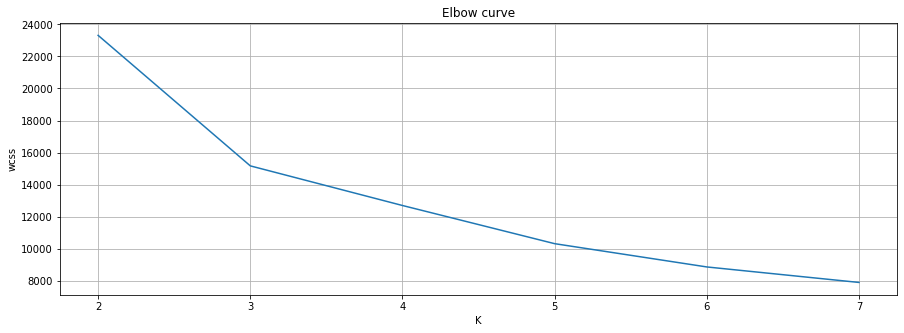

In [128]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the above elbow graph we got the number of clusters as 3

In [129]:
k_model=KMeans(n_clusters=3)
y_pred_model=k_model.fit_predict(df_scaled)

In [130]:
from sklearn.metrics import silhouette_score

In [131]:
clust_name=[]
sil_score=[]

In [132]:
silhouette_score(df_scaled,y_pred_model)

0.40192207053261203

In [133]:
clust_name.append('K-means')
sil_score.append(silhouette_score(df_scaled,y_pred_model))

In [134]:
clust_name

['K-means']

In [135]:
df_scaled_dataframe['cluster_label']=y_pred_model

In [136]:
df_scaled_dataframe.head()

,rating,polarity,cluster_label
0,0.856889,1.825639,2
1,0.856889,1.825639,2
2,0.856889,1.825639,2
3,0.856889,1.825639,2
4,0.856889,1.825639,2


In [137]:
df_clust_sel['cluster_label']=y_pred_model

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\917102093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel['cluster_label']=y_pred_model


In [138]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label
0,4.571429,0.42651,2
1,4.571429,0.42651,2
2,4.571429,0.42651,2
3,4.571429,0.42651,2
4,4.571429,0.42651,2


### Made three clusters as Best, Average and Good

In [139]:
fd=df_clust_sel.iloc[:, [0, 1]].values
fd

array([[4.57142857, 0.4265103 ],
       [4.57142857, 0.4265103 ],
       [4.57142857, 0.4265103 ],
       ...,
       [3.8       , 0.18746984],
       [3.8       , 0.18746984],
       [3.8       , 0.18746984]])

In [140]:
np.unique(y_pred_model)

array([0, 1, 2])

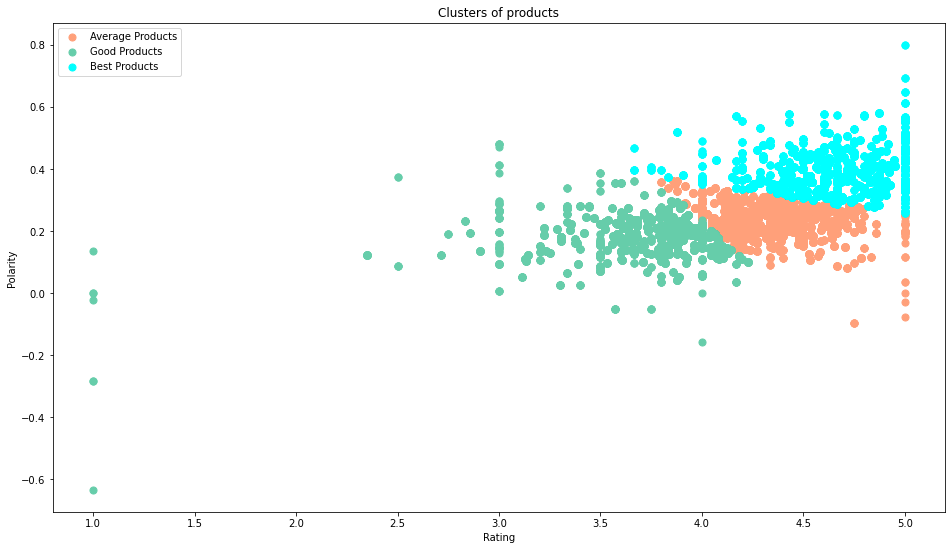

In [141]:
plt.figure(figsize=(16,9))
plt.scatter(fd[y_pred_model == 0, 0], fd[y_pred_model== 0, 1], s = 50, c = '#FFA07A',label = 'Average Products')
plt.scatter(fd[y_pred_model== 1, 0], fd[y_pred_model == 1, 1], s = 50, c = '#66CDAA',label='Good Products')#, label = 'Average Products')
plt.scatter(fd[y_pred_model == 2, 0], fd[y_pred_model== 2, 1], s = 50, c = '#00FFFF',label='Best Products')#, label = 'Best Products')
plt.title('Clusters of products')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

In [142]:
len(y_pred_model)

21272

In [143]:
df_clust['cluster_label']=y_pred_model


In [144]:
df_clust.head(1)

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price_x,...,verified,year,month,final_review,polarity_x,blobsentiment,rating_y,price_y,polarity_y,cluster_label
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.571429,30.0,0.42651,2


In [145]:
df_1=df_clust[['product_id','cluster_label']]
df_1.head()

,product_id,cluster_label
0,B00004U9V2,2
1,B00004U9V2,2
2,B00004U9V2,2
3,B00004U9V2,2
4,B00004U9V2,2


In [146]:
import numpy as np

### Giving the cluster lables to our dataset

In [147]:
df_1['labels']=df_1['cluster_label'].apply(lambda x:'Average products' if x==0 else 'Good products' if x ==1 else 'Best products')

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\3056830127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['labels']=df_1['cluster_label'].apply(lambda x:'Average products' if x==0 else 'Good products' if x ==1 else 'Best products')


In [148]:
df_1.head()

,product_id,cluster_label,labels
0,B00004U9V2,2,Best products
1,B00004U9V2,2,Best products
2,B00004U9V2,2,Best products
3,B00004U9V2,2,Best products
4,B00004U9V2,2,Best products


In [149]:
df_merge=pd.merge(df_1,df_final_dup,on='product_id',how='inner')
df_merge

,product_id,cluster_label,labels,index,reviewTime,reviewerID,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment
0,B00004U9V2,2,Best products,0,2018-01-05,A2HOI48JK8838M,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive
1,B00004U9V2,2,Best products,1,2016-08-14,A2HOI48JK8838M,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative
2,B00004U9V2,2,Best products,2,2017-04-05,A1YIPEY7HX73S7,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive
3,B00004U9V2,2,Best products,3,2017-03-27,A2QCGHIJ2TCLVP,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive
4,B00004U9V2,2,Best products,4,2017-02-28,A2QCGHIJ2TCLVP,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481881,B01DSY86YG,1,Good products,21267,2018-04-29,A1UQBFCERIP7VJ,This white lotion has a light citrus fragrance...,High C moisturizer,5.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,Margaret P.,False,2018,4,white lotion light citrus fragrance good job m...,0.243673,Positive
1481882,B01DSY86YG,1,Good products,21268,2018-04-22,AR9GZ8B7NJJPN,"I am a long-time user of vitamin C products, c...",High C night cream,3.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,JoAnne Goldberg,False,2018,4,long - time user vitamin c product currently a...,0.174956,Positive
1481883,B01DSY86YG,1,Good products,21269,2018-04-18,A2ZGPAIV64KOYU,I'm surprised by the negative reviews for this...,This is working for me. Noticeable improvement...,5.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,Curious Epicure,False,2018,4,surprised negative review product issue apply ...,-0.042727,Negative
1481884,B01DSY86YG,1,Good products,21270,2018-04-18,ACJ9N7ED37HXS,"I am a fan of this company, and this product, ...","Nice feel the next morning, contains 30% Vitam...",4.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,kstars,False,2018,4,fan company product exception fact ste bit app...,0.343265,Positive


In [150]:
df_final_dup.shape

(21272, 18)

In [151]:
df_merge.shape

(1481886, 20)

In [152]:
df_merge_dup= df_merge.drop_duplicates(subset = ['reviewerID', 'product_id','reviewTime'],keep = 'first').reset_index(drop = True)


In [159]:
df_merge_dup.groupby("product_segment").mean().loc[:,['rating','price','verified']]

,rating,price,verified
product_segment,,,
Average products,4.328423,34.931563,0.329273
Best products,4.551529,27.402348,0.850451
Good products,3.765174,44.566428,0.213333


<Figure size 1152x648 with 0 Axes>

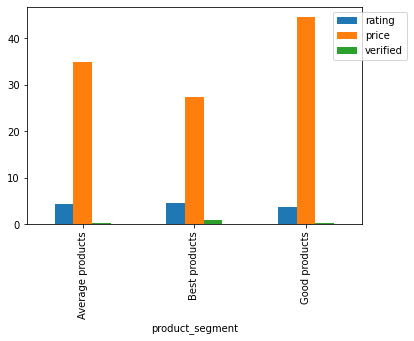

In [160]:
plt.figure(figsize=(16,9))
df_merge_dup.groupby("product_segment").mean().loc[:,['rating','price','verified']].plot(kind='bar')
plt.legend(bbox_to_anchor=(1.15,1),loc='upper right');

## (ii) Agglomerative

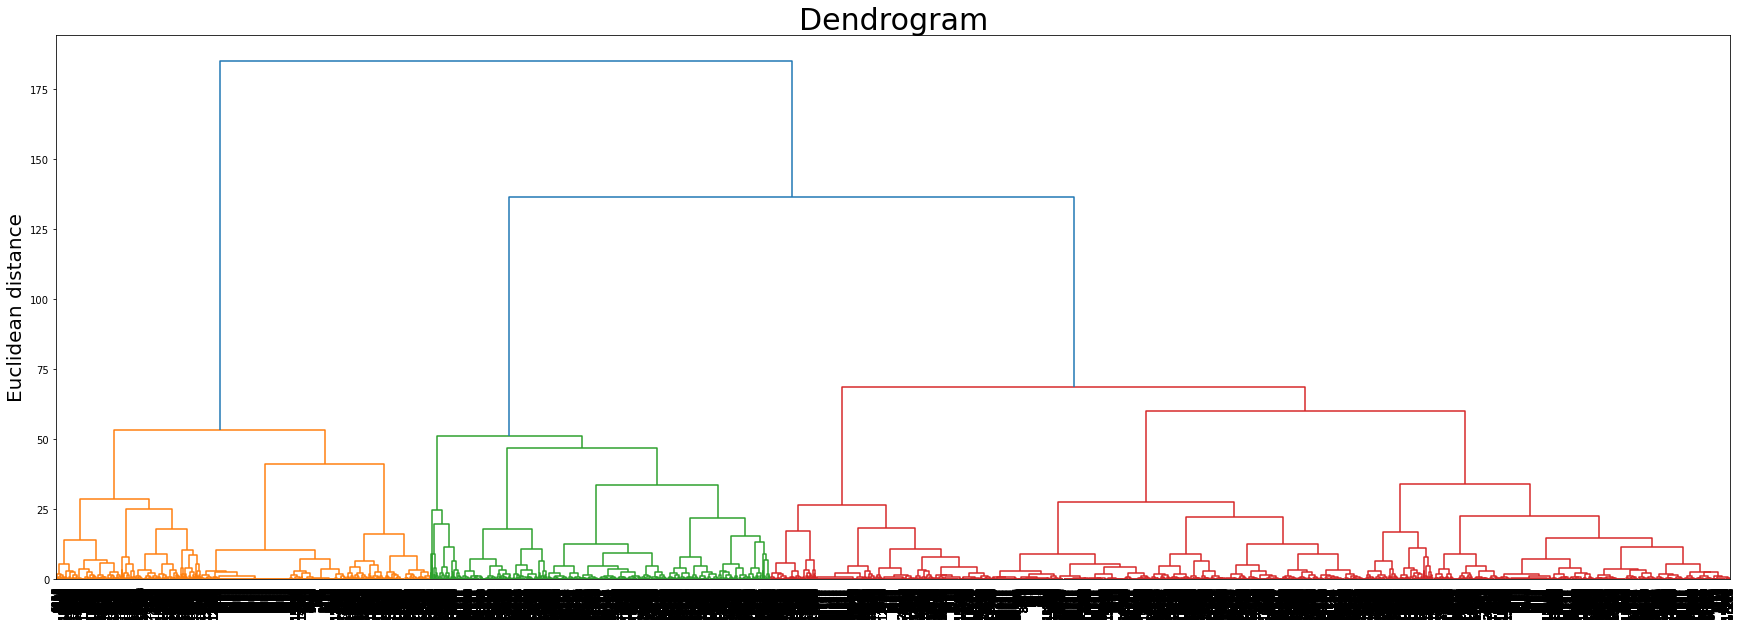

In [171]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled, method = 'ward'),labels=df_scaled_dataframe.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [172]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(df_scaled)

In [173]:
silhouette_score(df_scaled,y_hc)

0.37714379524191327

### Giving the cluster labels to our dataset

In [174]:

df_clust_sel['cluster_label_agglom']=y_hc

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\553158277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel['cluster_label_agglom']=y_hc


In [175]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label,cluster_label_agglom
0,4.571429,0.42651,2,1
1,4.571429,0.42651,2,1
2,4.571429,0.42651,2,1
3,4.571429,0.42651,2,1
4,4.571429,0.42651,2,1


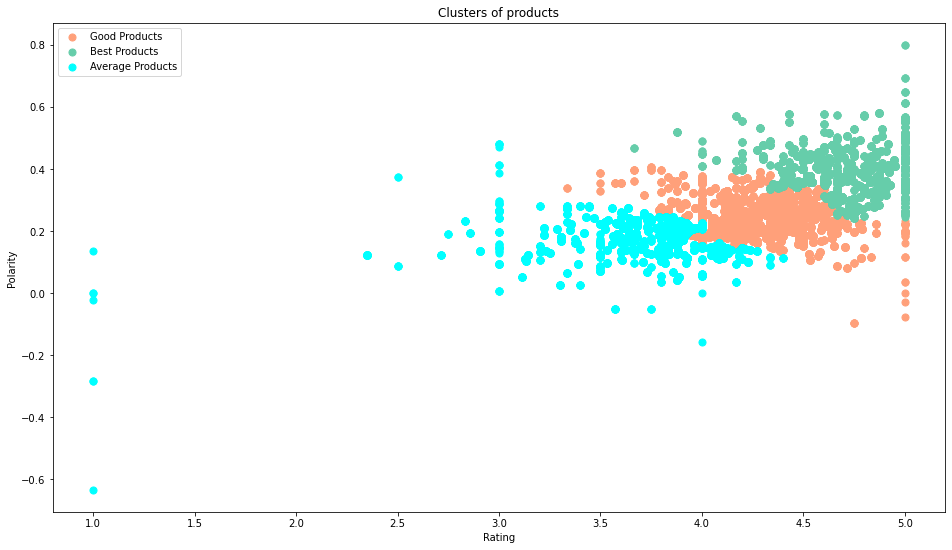

In [176]:
plt.figure(figsize=(16,9))
plt.scatter(fd[y_hc == 0, 0], fd[y_hc== 0, 1], s = 50, c = '#FFA07A', label = 'Good Products')
plt.scatter(fd[y_hc== 1, 0], fd[y_hc == 1, 1], s = 50, c = '#66CDAA', label = 'Best Products')
plt.scatter(fd[y_hc == 2, 0], fd[y_hc== 2, 1], s = 50, c = '#00FFFF', label = 'Average Products')
plt.title('Clusters of products')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

In [177]:
clust_name.append('Agglomerative clustering')
sil_score.append(silhouette_score(df_scaled,y_hc))

In [178]:
clust_name

['K-means', 'Agglomerative clustering']

### Comparision of kmeans with agglomerative

In [179]:
df_comp_clust=pd.DataFrame({"model":clust_name,"silhoutte_score":sil_score})
df_comp_clust

,model,silhoutte_score
0,K-means,0.401922
1,Agglomerative clustering,0.377144


#### Here we found that Kmeans is better

## Customer segmentation :


In [201]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive


In [202]:
df_rev=df_final.groupby('reviewerID').mean()[['rating','polarity']]
df_rev.reset_index(inplace=True)

### Checking the shape

In [203]:
df_seg_merge=pd.merge(df_final,df_rev,on='reviewerID',how='inner')
df_seg_merge.shape

(21272, 19)

In [204]:
df_seg_merge.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity_x,blobsentiment,rating_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.142857,0.321429
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.142857,0.321429
2,2017-03-30,A2HOI48JK8838M,B00396VE7U,I was gardening for three hours. No burn. Nice...,Great product.,5.0,Luxury Beauty,Revision Skincare Intellishade SPF 45 Original...,2445.0,75.0,DB,False,2017,3,garden hour no burn nice finished look product...,0.700000,Positive,4.142857,0.321429
3,2018-01-05,A2HOI48JK8838M,B00FASVFI8,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn Ultra-Moisturising Hand ...,60736.0,20.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.142857,0.321429
4,2016-08-14,A2HOI48JK8838M,B00FRERO7G,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...,13813.0,24.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.142857,0.321429


In [205]:
df_clust_sel_a=df_seg_merge[['rating_y','polarity_y']]
df_clust_sel_a.shape

(21272, 2)

### Sacling the data

In [206]:
scaler_a=StandardScaler()

In [207]:
df_scaled_a = scaler.fit_transform(df_clust_sel_a)
df_scaled_a

array([[-0.16507394,  0.37558578],
       [-0.16507394,  0.37558578],
       [-0.16507394,  0.37558578],
       ...,
       [ 1.10001058, -0.89158258],
       [ 1.10001058,  0.73023059],
       [-0.37592137,  1.07988039]])

In [208]:
df_scaled_dataframe_a=pd.DataFrame(df_scaled_a,columns=['rating', 'polarity'])
df_scaled_dataframe_a.head()

,rating,polarity
0,-0.165074,0.375586
1,-0.165074,0.375586
2,-0.165074,0.375586
3,-0.165074,0.375586
4,-0.165074,0.375586


## (i) Kmeans

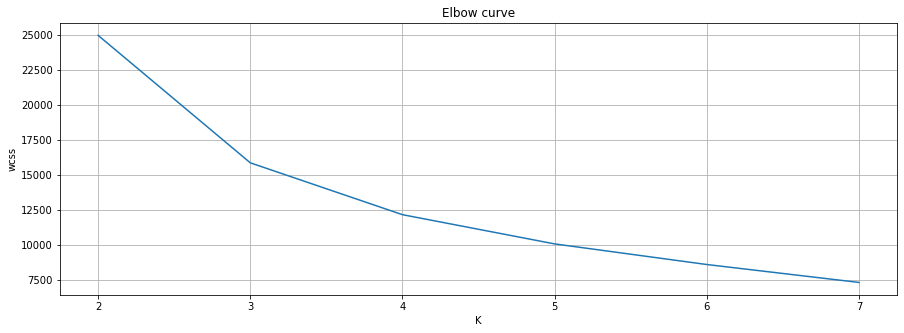

In [209]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled_a)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the elbow graph method we got no of clusters as 3

In [210]:
k_model_a=KMeans(n_clusters=3)
y_pred_model_a=k_model_a.fit_predict(df_scaled_a)

In [211]:
silhouette_score(df_scaled_a,y_pred_model_a)

0.4266421817434786

In [212]:
md_name=[]
si_score=[]

In [213]:
md_name.append('k-means')
si_score.append(silhouette_score(df_scaled_a,y_pred_model_a))

In [214]:
si_score

[0.4266421817434786]

In [215]:
md_name

['k-means']

In [216]:
df_clust_sel_a.head()

,rating_y,polarity_y
0,4.142857,0.321429
1,4.142857,0.321429
2,4.142857,0.321429
3,4.142857,0.321429
4,4.142857,0.321429


### Making the clusters 

In [217]:
df_clust_sel_a['cluster_label']=y_pred_model_a

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\3450533625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel_a['cluster_label']=y_pred_model_a


In [218]:
fd_1=df_clust_sel_a.iloc[:, [0, 1]].values
fd_1

array([[4.14285714, 0.32142857],
       [4.14285714, 0.32142857],
       [4.14285714, 0.32142857],
       ...,
       [5.        , 0.12008929],
       [5.        , 0.37777778],
       [4.        , 0.43333333]])

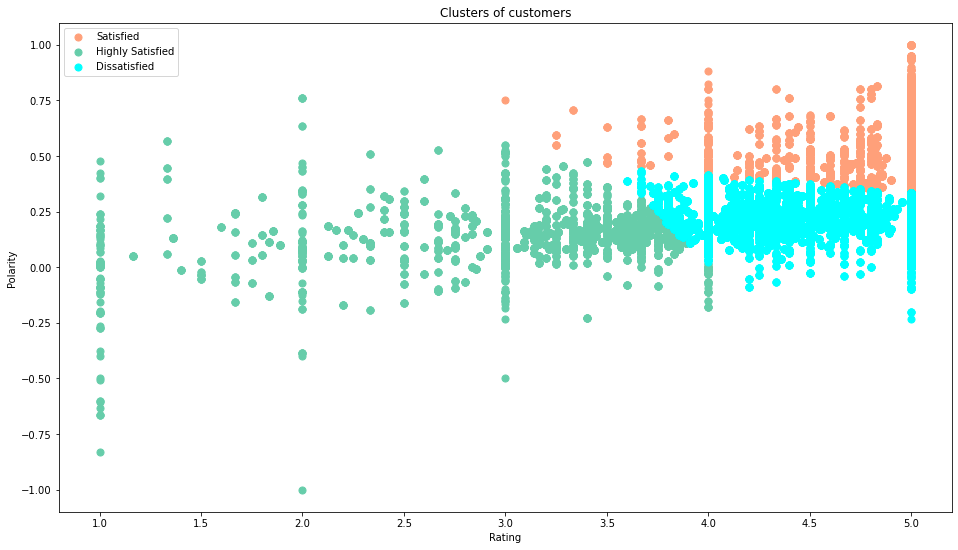

In [219]:
plt.figure(figsize=(16,9))
plt.scatter(fd_1[y_pred_model_a == 0, 0], fd_1[y_pred_model_a== 0, 1], s = 50, c = '#FFA07A', label = 'Satisfied')
plt.scatter(fd_1[y_pred_model_a== 1, 0], fd_1[y_pred_model_a == 1, 1], s = 50, c = '#66CDAA', label = 'Highly Satisfied')
plt.scatter(fd_1[y_pred_model_a == 2, 0], fd_1[y_pred_model_a== 2, 1], s = 50, c = '#00FFFF', label = 'Dissatisfied')
plt.title('Clusters of customers')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

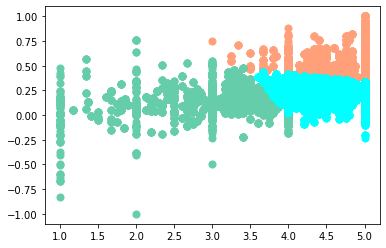

In [220]:
plt.scatter(fd_1[y_pred_model_a == 0, 0], fd_1[y_pred_model_a== 0, 1], s = 50, c = '#FFA07A')
plt.scatter(fd_1[y_pred_model_a== 1, 0], fd_1[y_pred_model_a == 1, 1], s = 50, c = '#66CDAA')
plt.scatter(fd_1[y_pred_model_a == 2, 0], fd_1[y_pred_model_a== 2, 1], s = 50, c = '#00FFFF')

### Assigning the cluster label to our dataset

In [221]:
df_seg_merge['cluster_label']=y_pred_model_a

In [222]:
df_2=df_seg_merge[['reviewerID','cluster_label']]
df_2

,reviewerID,cluster_label
0,A2HOI48JK8838M,2
1,A2HOI48JK8838M,2
2,A2HOI48JK8838M,2
3,A2HOI48JK8838M,2
4,A2HOI48JK8838M,2
...,...,...
21267,A1YLRQL1XZBKCS,1
21268,A1S7TXHM2VM5EF,2
21269,A1S7TXHM2VM5EF,2
21270,A20W9PSUAKDRN1,0


In [223]:
df_2['labels']=df_2['cluster_label'].apply(lambda x:'Satisfied Customers' if x==1 else 'Highly Satisfied Customers' if x ==0 else 'Disatisfied Customers')

C:\Users\Asus\AppData\Local\Temp\ipykernel_1292\1868706011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['labels']=df_2['cluster_label'].apply(lambda x:'Satisfied Customers' if x==1 else 'Highly Satisfied Customers' if x ==0 else 'Disatisfied Customers')


In [224]:
df_2

,reviewerID,cluster_label,labels
0,A2HOI48JK8838M,2,Disatisfied Customers
1,A2HOI48JK8838M,2,Disatisfied Customers
2,A2HOI48JK8838M,2,Disatisfied Customers
3,A2HOI48JK8838M,2,Disatisfied Customers
4,A2HOI48JK8838M,2,Disatisfied Customers
...,...,...,...
21267,A1YLRQL1XZBKCS,1,Satisfied Customers
21268,A1S7TXHM2VM5EF,2,Disatisfied Customers
21269,A1S7TXHM2VM5EF,2,Disatisfied Customers
21270,A20W9PSUAKDRN1,0,Highly Satisfied Customers


In [225]:
df_final_dup

,index,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment
0,0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive
1,1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative
2,2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive
3,3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive
4,4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.000,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21267,21267,2018-04-29,A1UQBFCERIP7VJ,B01DSY86YG,This white lotion has a light citrus fragrance...,High C moisturizer,5.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,Margaret P.,False,2018,4,white lotion light citrus fragrance good job m...,0.243673,Positive
21268,21268,2018-04-22,AR9GZ8B7NJJPN,B01DSY86YG,"I am a long-time user of vitamin C products, c...",High C night cream,3.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,JoAnne Goldberg,False,2018,4,long - time user vitamin c product currently a...,0.174956,Positive
21269,21269,2018-04-18,A2ZGPAIV64KOYU,B01DSY86YG,I'm surprised by the negative reviews for this...,This is working for me. Noticeable improvement...,5.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,Curious Epicure,False,2018,4,surprised negative review product issue apply ...,-0.042727,Negative
21270,21270,2018-04-18,ACJ9N7ED37HXS,B01DSY86YG,"I am a fan of this company, and this product, ...","Nice feel the next morning, contains 30% Vitam...",4.0,Luxury Beauty,Dermatologic Cosmetic Laboratories C Scape Nig...,277840.0,85.525,kstars,False,2018,4,fan company product exception fact ste bit app...,0.343265,Positive


In [226]:
df_final.shape

(21272, 17)

## (ii) Agglomerative

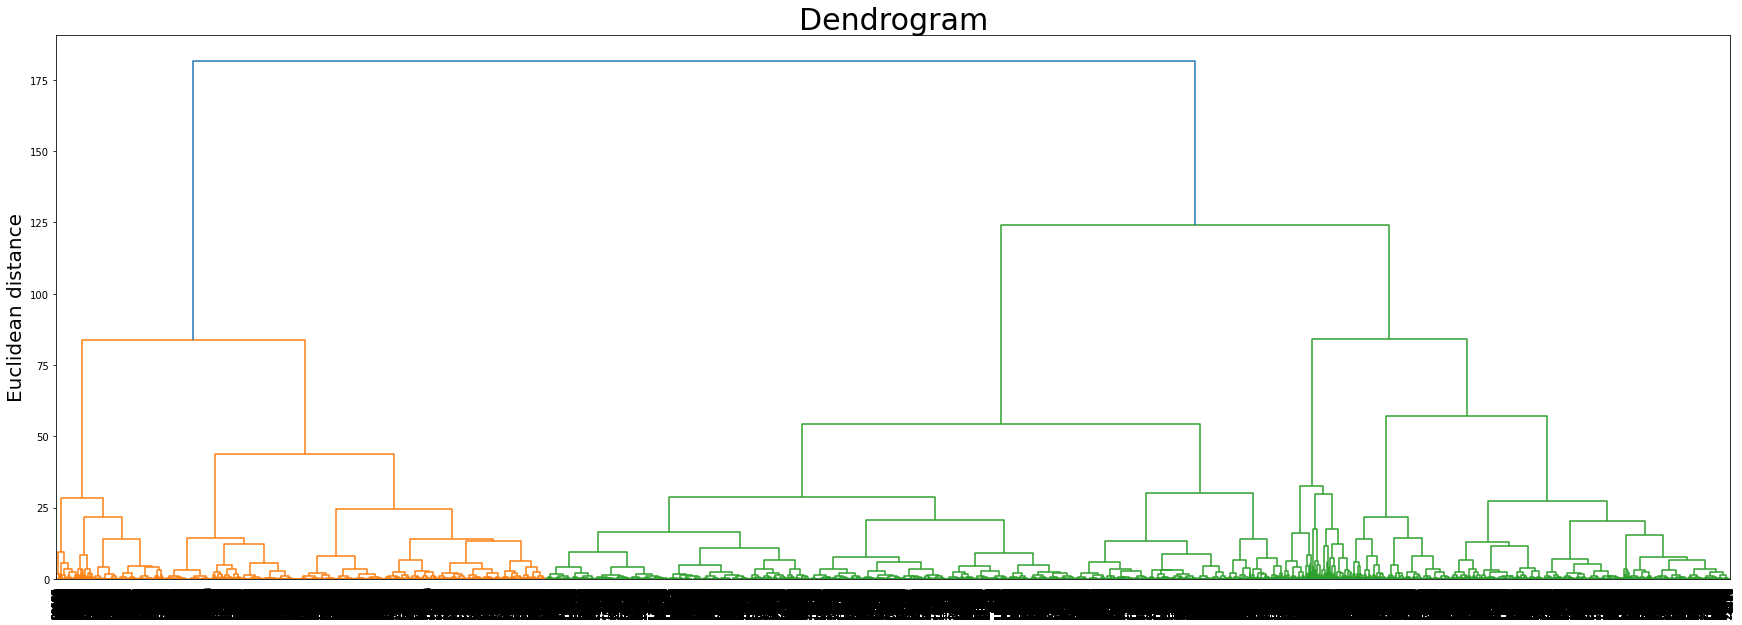

In [236]:
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled_a, method = 'ward'),labels=df_scaled_dataframe_a.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [237]:
hc_a= AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc_a= hc.fit_predict(df_scaled_a)

In [238]:
md_name.append('agglomerative')
si_score.append(silhouette_score(df_scaled_a,y_hc_a))

In [239]:
md_name

['k-means', 'agglomerative']

In [240]:
si_score

[0.4266421817434786, 0.3385473116045488]

### Comparing the clustering models 

In [241]:
df_comp_clust_agg=pd.DataFrame({"model":md_name,"silhoutte_score":si_score})
df_comp_clust_agg

,model,silhoutte_score
0,k-means,0.426642
1,agglomerative,0.338547


#### Here we got that K means is better

In [251]:
df_merge_1=pd.merge(df_merge,df_2,on='reviewerID',how='inner')
df_merge_1=df_merge_1.drop_duplicates()

In [252]:
df_merge_1

,product_id,cluster_label_x,labels_x,index,reviewTime,reviewerID,reviewText,summary,rating,main_cat,...,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment,cluster_label_y,labels_y
0,B00004U9V2,2,Best products,0,2018-01-05,A2HOI48JK8838M,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,...,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,2,Disatisfied Customers
7,B00004U9V2,2,Best products,1,2016-08-14,A2HOI48JK8838M,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,...,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,2,Disatisfied Customers
294,B00396VE7U,2,Best products,8273,2017-03-30,A2HOI48JK8838M,I was gardening for three hours. No burn. Nice...,Great product.,5.0,Luxury Beauty,...,75.0,DB,False,2017,3,garden hour no burn nice finished look product...,0.700000,Positive,2,Disatisfied Customers
434,B00FASVFI8,2,Best products,13818,2018-01-05,A2HOI48JK8838M,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,...,20.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,2,Disatisfied Customers
483,B00FRERO7G,2,Best products,13937,2016-08-14,A2HOI48JK8838M,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,...,24.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,2,Disatisfied Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12493953,B01DQG3DFI,0,Average products,20386,2012-12-31,A1YLRQL1XZBKCS,See description above. The London Butter nail ...,"Shop Adorn's polish was pasty, thick and left ...",1.0,Luxury Beauty,...,15.0,Bluebird,True,2012,12,description london butter nail lacquer purchas...,-0.157143,Negative,1,Satisfied Customers
12494015,B01DQG3DFI,0,Average products,20387,2012-09-25,A1S7TXHM2VM5EF,The butter London brand lacquer has turned me ...,"Love this shade, snog",5.0,Luxury Beauty,...,15.0,Brittany Partin,False,2012,9,butter london brand lacquer turn polish snob t...,0.218750,Positive,2,Disatisfied Customers
12494017,B01DQG3DFI,0,Average products,20388,2012-09-07,A1S7TXHM2VM5EF,"This polish, as with many glitter polishes, sh...",Exactly what I wanted!,5.0,Luxury Beauty,...,15.0,Brittany Partin,False,2012,9,polish glitter polish base coat french pink sh...,0.021429,Positive,2,Disatisfied Customers
12494263,B01DQG3DFI,0,Average products,20390,2012-09-11,A20W9PSUAKDRN1,This Butter brand polish has added to my colle...,Love the Butter range!,5.0,Luxury Beauty,...,15.0,ViWo,False,2012,9,butter brand polish add collection brand colou...,0.377778,Positive,0,Highly Satisfied Customers


In [253]:
df_merge_1.rename(columns={"labels_x":"product_segment","labels_y":"customer_category"},inplace=True)

In [254]:
df_merge_1.head()

,product_id,cluster_label_x,product_segment,index,reviewTime,reviewerID,reviewText,summary,rating,main_cat,...,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment,cluster_label_y,customer_category
0,B00004U9V2,2,Best products,0,2018-01-05,A2HOI48JK8838M,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,...,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,2,Disatisfied Customers
7,B00004U9V2,2,Best products,1,2016-08-14,A2HOI48JK8838M,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,...,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,2,Disatisfied Customers
294,B00396VE7U,2,Best products,8273,2017-03-30,A2HOI48JK8838M,I was gardening for three hours. No burn. Nice...,Great product.,5.0,Luxury Beauty,...,75.0,DB,False,2017,3,garden hour no burn nice finished look product...,0.700000,Positive,2,Disatisfied Customers
434,B00FASVFI8,2,Best products,13818,2018-01-05,A2HOI48JK8838M,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,...,20.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,2,Disatisfied Customers
483,B00FRERO7G,2,Best products,13937,2016-08-14,A2HOI48JK8838M,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,...,24.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,2,Disatisfied Customers


In [255]:
df_merge_1['product_segment'].value_counts()

Average products    10590
Best products        5657
Good products        5025
Name: product_segment, dtype: int64

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


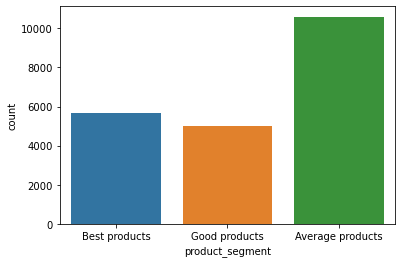

In [256]:
sns.countplot(df_merge_1['product_segment']);

In [266]:
df_merge_1.to_csv("segment.csv",index=False)